In [1]:
import pandas as pd
import os
import datetime as dt
from datetime import date as date_func
import random

In [2]:
import pickle
import glob
import re
import os
import copy
import subprocess
import timeit
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from functools import reduce

import vcf
import pysam
import numpy as np
import pandas as pd
import dask.dataframe as dd
from Bio import SeqIO
from Bio.SeqUtils import seq1

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [4]:
from scipy.stats import fisher_exact, chi2_contingency

# Sampling

In [5]:
metadata = pd.read_csv('PRJNA764181.filtered.csv')

In [6]:
metadata = metadata.set_index('Run')

In [7]:
metadata['Collection_Date'] =  pd.to_datetime(metadata['Collection_Date'], format='%Y-%m-%d')

In [8]:
sampling_date_start = pd.to_datetime('12/06/2021')
weekdays = timedelta(days=7)
sampling_date_end = sampling_date_start + 8 * weekdays
samples_in_range = metadata[(metadata['Collection_Date'] >= sampling_date_start) & (metadata['Collection_Date'] < sampling_date_end)].index.to_list()

In [9]:
len(samples_in_range)

5060

In [10]:
sampled_metadata = metadata.copy()
sampled_metadata

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,Collection_Date,Consent,...,raw_sequence_data_processing_method (run),ReleaseDate,create_date,version,Sample Name,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex
Run,,,,,,,,,,,,,,,,,,,,,
SRR17385361,WGS,146,315053090,PRJNA764181,SAMN24526781,SARS-CoV-2: clinical or host-associated,142251355,DISEASE PREVENTION AND CONTROL,2021-12-14,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female
SRR17385362,WGS,152,281371912,PRJNA764181,SAMN24526601,SARS-CoV-2: clinical or host-associated,127877961,DISEASE PREVENTION AND CONTROL,2021-12-14,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN
SRR17385363,WGS,152,154251120,PRJNA764181,SAMN24526583,SARS-CoV-2: clinical or host-associated,72785188,DISEASE PREVENTION AND CONTROL,2021-12-15,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112200163,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",31.0,NaN,female
SRR17385364,WGS,146,222184820,PRJNA764181,SAMN24526780,SARS-CoV-2: clinical or host-associated,99844851,DISEASE PREVENTION AND CONTROL,2021-12-14,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218591,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",68.0,NaN,female
SRR17385365,WGS,146,315530318,PRJNA764181,SAMN24526779,SARS-CoV-2: clinical or host-associated,143143883,DISEASE PREVENTION AND CONTROL,2021-12-14,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218520,SRP337649,CAMBRIDGE HEALTH AND REHAB - 1106 GOLFVIEW DRIVE,53.0,NaN,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR18133353,WGS,148,362853376,PRJNA764181,SAMN26233067,SARS-CoV-2: clinical or host-associated,152487576,DISEASE PREVENTION AND CONTROL,2021-12-22,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:23:00Z,2,TX-HHD-2201056720,SRP337649,"GALE\, LETOSHA",61.0,VarSkip,NaN
SRR18133354,WGS,602,253916978,PRJNA764181,SAMN26232815,SARS-CoV-2: clinical or host-associated,173718018,DISEASE PREVENTION AND CONTROL,2021-12-23,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:23:00Z,2,TX-HHD-2201141431,SRP337649,"GALE\, LETOSHA",9.0,VarSkip,NaN
SRR18133355,WGS,148,195528424,PRJNA764181,SAMN26233066,SARS-CoV-2: clinical or host-associated,80031811,DISEASE PREVENTION AND CONTROL,2021-12-22,public,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:22:00Z,2,TX-HHD-2201056655,SRP337649,"GALE\, LETOSHA",71.0,VarSkip,NaN


# Search Target Cryptic 

In [11]:
output = '/home/Users/yl181/wastewater/quaid/output_incl_recombinant'
dbs = '/home/Users/yl181/wastewater/quaid/quarc_dbs_01102023_incl_recombinant'

In [12]:
merged_df = pd.read_csv('/home/Users/yl181/wastewater/quarc_figures/merged_df.csv', index_col=0)
merged_df['Date'] = merged_df['Date'].apply(str)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%Y-%m-%d')
len(merged_df['Nt Mutations'].unique())

6818

In [13]:
merged_df

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
0,2022-01-06,203,A13098G;T13195C,ORF1a:K4278R;ORF1a:V4310V,8,119,0.067227
1,2022-01-06,203,T23599G;C23604A;G23642T,S:N679K;S:P681H;S:A694S,5,30,0.166667
2,2022-01-06,69,A24966T;C25000T,S:N1135I;S:D1146D,5,56,0.089286
3,2022-01-06,69,A29039T;G29049A,N:K256*;N:R259Q,8,380,0.021053
4,2022-01-06,76,G28881A;G28882A;G28883C;G28931T,N:R203K;N:R203R;N:G204R;N:A220S,5,99,0.050505
...,...,...,...,...,...,...,...
11474,2021-12-30,WD,C15805A;A15812T,ORF1b:Q780K;ORF1b:N782I,17,553,0.030741
11475,2021-12-30,WD,C24130A;A24250G,S:N856K;S:I896M,8,107,0.074766
11476,2021-12-30,WD,A24966T;C25000T,S:N1135I;S:D1146D,45,1547,0.029089
11477,2021-12-30,WD,G28881A;G28882A;G28883C;A29039T,N:R203K;N:R203R;N:G204R;N:K256*,14,324,0.043210


In [14]:
file_to_read = open(os.path.join(output, "query_result.pkl"), "rb")
query_result = pickle.load(file_to_read)

In [15]:
count_rarity_dict = dict()
for key in query_result:
    count_rarity_dict[key] = sum(query_result[key].values())
gisaid_count_df = pd.DataFrame.from_dict(count_rarity_dict, columns=['GISAID Count'], orient='index')

site_count_df = pd.DataFrame(merged_df.groupby('Nt Mutations')['Site'].count())
mutation_rarity_df = site_count_df.merge(gisaid_count_df, left_index=True, right_index=True, validate='one_to_one')

In [16]:
min_site = 2
gisaid_total_count = 12988494
max_gisaid_occurance = 0.0001 * gisaid_total_count
print('max_gisaid_occurance:', max_gisaid_occurance)

selected_data = mutation_rarity_df[(mutation_rarity_df['Site'] >= min_site) & (mutation_rarity_df['GISAID Count'] <= max_gisaid_occurance)].copy()
selected_data = selected_data.rename({'Site': 'Mutation Occurance'}, axis=1)
len(selected_data)

max_gisaid_occurance: 1298.8494


716

In [17]:
selected_data

,Mutation Occurance,GISAID Count
A1003G;C913T,5,95
A10195G;C10252T,9,14
A10195G;C10277T,3,33
A10195G;C10319T,7,3
A10195G;C10332T,2,12
...,...,...
T7233G;A7234T;G7235T,2,0
T847A;C913T,10,293
T886C;C913T,2,71
T8915C;C8986T,3,120


In [18]:
days_offset = dt.timedelta(days = 0)

In [19]:
cryptic_in_date_range = merged_df[(merged_df['Date'] >= sampling_date_start - days_offset) & (merged_df['Date'] < sampling_date_end)]['Nt Mutations'].unique()

In [20]:
target_cryptic_df = pd.DataFrame(columns=['Nt Mutations', 'Mutation Occurance', 'GISAID Count'])
for cryptic_mutation in cryptic_in_date_range:
    try:
        record_dict = {'Nt Mutations': cryptic_mutation,
               'Mutation Occurance': selected_data.loc[cryptic_mutation]['Mutation Occurance'],
               'GISAID Count': selected_data.loc[cryptic_mutation]['GISAID Count']}
        target_cryptic_df = target_cryptic_df.append(record_dict, ignore_index=True)
    except KeyError:
        continue

In [21]:
week_counts = []
mut_occurance = []
for cryptic_mutation in target_cryptic_df['Nt Mutations']:
    temp_df = merged_df[(merged_df['Nt Mutations'] == cryptic_mutation) & (merged_df['Date'] >= sampling_date_start - days_offset) & (merged_df['Date'] < sampling_date_end)]
    week_count = len(temp_df['Date'].unique())
    mut_occurance.append(temp_df.shape[0])
    week_counts.append(week_count)

target_cryptic_df['Week Count'] = week_counts
target_cryptic_df['Mutation Occurance'] = mut_occurance

In [22]:
target_cryptic_df = target_cryptic_df[target_cryptic_df['Week Count'] >= 2].sort_values(by=['Week Count', 'Mutation Occurance', 'GISAID Count'], ascending=[True, False, True])

In [23]:
target_cryptic_df.iloc[0:10]

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count
85,A29039T;G29049A;A29301G,6,0,2
87,G29050A;A29301G,6,15,2
65,A26530G;C26577G;G26634A,4,1,2
53,T13078C;T13195C,4,24,2
24,A26530G;C26533T;C26542A;T26545G,3,1,2
15,T28823G;G28881A;G28882A;G28883C,3,4,2
68,A27259C;C27335T;A27344T;A27345T,3,4,2
67,A26530G;T26545G,3,6,2
117,C27807T;A27821C,3,12,2
83,C6402T;G6456A,3,153,2


In [24]:
target_cryptic_df.iloc[-10:]

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count
41,G22959T;G22992A;C22995A;A23013C;A23040G;G23048...,4,0,4
16,G28881A;G28882A;G28883C;G28954T,4,69,4
25,A26530G;C26577G;C26625A,32,4,5
20,C10449A;T10459C,19,169,5
5,T15682A;T15685A,14,6,5
4,T29029C;A29039T,8,5,5
1,A24966T;C25000T,82,10,6
27,A27344T;A27345T;A27354G,11,10,6
0,T23599G;C23604A;G23642T,10,29,7
2,A29039T;G29049A,67,3,8


In [25]:
target_cryptic_list = target_cryptic_df['Nt Mutations'].to_list()

selected_cryptic_mutations = target_cryptic_list[0:10]+target_cryptic_list[-10:]
selected_cryptic_mutations

['A29039T;G29049A;A29301G',
 'G29050A;A29301G',
 'A26530G;C26577G;G26634A',
 'T13078C;T13195C',
 'A26530G;C26533T;C26542A;T26545G',
 'T28823G;G28881A;G28882A;G28883C',
 'A27259C;C27335T;A27344T;A27345T',
 'A26530G;T26545G',
 'C27807T;A27821C',
 'C6402T;G6456A',
 'G22959T;G22992A;C22995A;A23013C;A23040G;G23048A;A23055G;A23063T;T23075C',
 'G28881A;G28882A;G28883C;G28954T',
 'A26530G;C26577G;C26625A',
 'C10449A;T10459C',
 'T15682A;T15685A',
 'T29029C;A29039T',
 'A24966T;C25000T',
 'A27344T;A27345T;A27354G',
 'T23599G;C23604A;G23642T',
 'A29039T;G29049A']

In [26]:
full_selected_cryptic_mutations = selected_cryptic_mutations.copy()

In [27]:
target_mutation = 'A29039T;G29049A'

In [28]:
target_mutation in selected_cryptic_mutations

True

# Validate Reads

In [29]:
def check_bam_index(sorted_bam_f, force_index=False):
    '''
    check whether BAM file has been indexed, if not, create index.
    '''
    if os.path.exists(sorted_bam_f):
        if (not os.path.exists(f"{sorted_bam_f}.bai")) or force_index:
            subprocess.run(["samtools", "index", sorted_bam_f], check=True)
    else:
        print(f"Error: {sorted_bam_f} does not exist.")

In [30]:
def fetch_cryptic_alignment(valid_cryptic_read_ids, sorted_bam_f, sample_id, output_dir):
    if len(valid_cryptic_read_ids) > 0:
        with open(f"{output_dir}/{sample_id}_cryptic_read_ids.txt", "w") as read_id_f:
            for read_id in valid_cryptic_read_ids:
                read_id_f.write(f"{read_id}\n")

        subprocess.run(['samtools', 'view', '-b',
                    '-N', f"{output_dir}/{sample_id}_cryptic_read_ids.txt",
                    '-o', f"{output_dir}/{sample_id}_cryptic_reads.bam",
                    sorted_bam_f],
                   check=True)

        check_bam_index(f"{output_dir}/{sample_id}_cryptic_reads.bam", force_index=True)

In [31]:
def get_reads_in_region(sorted_bam_f, target_mutation, reference, read_end_cutoff=5):
    check_bam_index(sorted_bam_f, force_index=False)
    samfile = pysam.AlignmentFile(sorted_bam_f, "rb", check_sq=False)
    
    read_id_dict = defaultdict(set)
    target_mutation_set = set(target_mutation.split(";"))
    
    for variant_nt_label in target_mutation_set:
        record_pos = int(variant_nt_label[1:-1])
        record_ref = variant_nt_label[0]
        record_alt = variant_nt_label[-1]
        
        for pileupcolumn in samfile.pileup(reference.id, int(record_pos)-1, int(record_pos), min_base_quality=0, max_depth=0):
            if pileupcolumn.reference_pos == int(record_pos)-1:
                aligned_reads = pileupcolumn.pileups
                for i, base in enumerate(pileupcolumn.get_query_sequences()):
                    read_length = aligned_reads[i].alignment.query_length
                    query_pos = pileupcolumn.get_query_positions()[i] # position of the query base
                    dist_to_end = min(abs(read_length-query_pos-1), query_pos) # distance to the ends
                    if dist_to_end > read_end_cutoff:
                        if base == str(record_alt) or base == str(record_alt).lower():
                            read_id_dict[aligned_reads[i].alignment.query_name].add(variant_nt_label)
                        else:
                            read_id_dict[aligned_reads[i].alignment.query_name].add(record_ref+str(record_pos)+base.lower())
    
    total_dp = 0
    supp_dp = 0
    valid_cryptic_read_ids = []
    for read_id in read_id_dict:
        if len(read_id_dict[read_id]) == len(target_mutation_set):
            total_dp += 1
            if read_id_dict[read_id] == target_mutation_set:
                supp_dp += 1
                valid_cryptic_read_ids.append(read_id)
    
    return valid_cryptic_read_ids, supp_dp, total_dp 

In [32]:
def worker(idx, sample_id, selected_cryptic_mutations):
    sample_cryptic_df = pd.DataFrame(columns=['SRA Accession ID', 'Run Index', 'Nt Mutations', 'Support DP', 'Total DP', 'Combined Freq'])
    sorted_bam_f = os.path.join(harvest_output_dir, f"{idx}_out", "bam_files", f"{sample_id}.sorted.bam")
    if os.path.exists(sorted_bam_f):
        cryptic_bam_files_dir = os.path.join(harvest_output_dir, f"{idx}_out", "cryptic_bam_files")
        if not os.path.exists(cryptic_bam_files_dir):
            os.mkdir(cryptic_bam_files_dir)
                
        for target_mutation in selected_cryptic_mutations:
            target_mutation_label = target_mutation.replace(";", "_")
            valid_cryptic_read_ids, supp_dp, total_dp = get_reads_in_region(sorted_bam_f, target_mutation, reference)

            output_dir = os.path.join(cryptic_bam_files_dir, target_mutation_label)
            if not os.path.exists(output_dir):
                os.mkdir(output_dir)
            
            if total_dp != 0:
                record_dict = {'SRA Accession ID': sample_id,
                               'Run Index': idx,
                               'Nt Mutations': target_mutation,
                               'Support DP': supp_dp,
                               'Total DP': total_dp,
                               'Combined Freq': supp_dp/total_dp}
            else:
                record_dict = {'SRA Accession ID': sample_id,
                               'Run Index': idx,
                               'Nt Mutations': target_mutation,
                               'Support DP': supp_dp,
                               'Total DP': total_dp,
                               'Combined Freq': np.nan}

            sample_cryptic_df = sample_cryptic_df.append(record_dict, ignore_index=True)
            fetch_cryptic_alignment(valid_cryptic_read_ids, sorted_bam_f, sample_id, output_dir)
    else:
        print(idx, sample_id, 'BAM does not exists.')
        
    return sample_cryptic_df

In [33]:
# reference = SeqIO.read("/home/Users/yl181/wastewater/SARS-CoV-2-reference.fasta", "fasta")
# harvest_output_dir = "/home/Users/yl181/cdc_harvest_variants/Proposed_Pipeline_SRA_Outputs_Quarc"

In [34]:
# clinical_cryptic_df = pd.DataFrame(columns=['SRA Accession ID', 'Run Index', 'Nt Mutations', 'Support DP', 'Total DP', 'Combined Freq'])

# df_list = []
# for idx, sample_id in enumerate(samples_in_range[0:2]):
#     sample_cryptic_df = worker(idx, sample_id, selected_cryptic_mutations)
#     df_list.append(sample_cryptic_df)

In [35]:
# clinical_cryptic_df = pd.concat(df_list, ignore_index=True)

# Houston Analysis

## Quality Control

In [36]:
clinical_cryptic_df = pd.read_csv('houston_clinical_20_dp4.csv')
houston_lineage_df = pd.read_csv("houston_lineage_report.csv")[['taxon', 'lineage']]

In [37]:
clinical_cryptic_df = clinical_cryptic_df.merge(sampled_metadata, how='left', left_on='SRA Accession ID', right_index=True)
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,raw_sequence_data_processing_method (run),ReleaseDate,create_date,version,Sample Name,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex
0,SRR17385361,0,A29039T;G29049A;A29301G,0,113,0,0,0,0,0,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female
1,SRR17385361,0,G29050A;A29301G,0,164,0,0,0,0,0,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female
2,SRR17385361,0,A26530G;C26577G;G26634A,0,1,0,0,0,0,0,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female
3,SRR17385361,0,T13078C;T13195C,0,231,0,0,0,0,0,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female
4,SRR17385361,0,A26530G;C26533T;C26542A;T26545G,0,1508,242,1195,0,0,0,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2021-12-30T00:00:00Z,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101195,SRR18133357,5059,T29029C;A29039T,6,1517,1080,1105,3,6,3,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN
101196,SRR18133357,5059,A24966T;C25000T,10,1818,1034,851,10,1,1,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN
101197,SRR18133357,5059,A27344T;A27345T;A27354G,13,1343,877,838,11,4,2,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN
101198,SRR18133357,5059,T23599G;C23604A;G23642T,0,670,258,186,0,0,0,...,BWA Version: 0.7.17-r1188; iVar version 1.2.2,2022-02-24T00:00:00Z,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN


In [38]:
clinical_cryptic_df = clinical_cryptic_df.merge(houston_lineage_df, how='left', left_on='SRA Accession ID', right_on='taxon')

In [39]:
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,create_date,version,Sample Name,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex,taxon,lineage
0,SRR17385361,0,A29039T;G29049A;A29301G,0,113,0,0,0,0,0,...,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15
1,SRR17385361,0,G29050A;A29301G,0,164,0,0,0,0,0,...,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15
2,SRR17385361,0,A26530G;C26577G;G26634A,0,1,0,0,0,0,0,...,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15
3,SRR17385361,0,T13078C;T13195C,0,231,0,0,0,0,0,...,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15
4,SRR17385361,0,A26530G;C26533T;C26542A;T26545G,0,1508,242,1195,0,0,0,...,2022-04-21T00:11:00Z,2,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101195,SRR18133357,5059,T29029C;A29039T,6,1517,1080,1105,3,6,3,...,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20
101196,SRR18133357,5059,A24966T;C25000T,10,1818,1034,851,10,1,1,...,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20
101197,SRR18133357,5059,A27344T;A27345T;A27354G,13,1343,877,838,11,4,2,...,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20
101198,SRR18133357,5059,T23599G;C23604A;G23642T,0,670,258,186,0,0,0,...,2022-04-21T00:23:00Z,2,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20


In [40]:
combined_freq = []
p_value = []
sb_value = []
supp_dp_updated = []
for idx, row in clinical_cryptic_df.iterrows():
    supp_dp = row['Support DP'] - row['Inconsistent Support DP']
    supp_dp_updated.append(supp_dp)
    
    total_dp = row['Total DP']
    if total_dp != 0:
        combined_freq.append(supp_dp/total_dp)
    else:
        combined_freq.append(np.nan)
    
    dp1, dp2, dp3, dp4 = row['DP1'], row['DP2'], row['DP3'], row['DP4']
    
    if dp3+dp4 > 0 and (dp3/(dp3+dp4) > 0.85 or dp3/(dp3+dp4) < 1-0.85):
        p_value.append(fisher_exact([[dp1, dp2], [dp3, dp4]])[1])
        try:
            sb_value.append(abs((dp3/(dp1+dp3)) - (dp4/(dp2+dp4)))/((dp3+dp4)/(dp1+dp2+dp3+dp4)))
        except ZeroDivisionError:
            sb_value.append(0)
    else:
        p_value.append(1)
        sb_value.append(0)

In [41]:
clinical_cryptic_df['Combined Freq'] = combined_freq
clinical_cryptic_df['SB_p_value'] = p_value
clinical_cryptic_df['SB'] = sb_value
clinical_cryptic_df['Support DP'] = supp_dp_updated

In [42]:
clinical_cryptic_df[(clinical_cryptic_df['Overlapping Support DP'] >= 10)]

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Sample Name,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex,taxon,lineage,SB_p_value,SB
27,SRR17385362,1,A26530G;T26545G,53,2365,1452,1582,13,52,12,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
33,SRR17385362,1,C10449A;T10459C,98,3045,2049,1946,38,97,37,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
34,SRR17385362,1,T15682A;T15685A,61,2474,1689,1780,32,50,21,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
35,SRR17385362,1,T29029C;A29039T,28,3876,2584,2598,12,28,12,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
37,SRR17385362,1,A27344T;A27345T;A27354G,49,2020,1370,1262,45,20,16,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101154,SRR18133355,5057,T15682A;T15685A,53,3529,2254,2455,29,38,14,...,TX-HHD-2201056655,SRP337649,"GALE\, LETOSHA",71.0,VarSkip,NaN,SRR18133355,BA.1.15,1.0,0.0
101173,SRR18133356,5058,C10449A;T10459C,27,1979,1279,1180,10,27,10,...,TX-HHD-2201146651,SRP337649,"GALE\, LETOSHA",25.0,VarSkip,NaN,SRR18133356,BA.1.15,1.0,0.0
101174,SRR18133356,5058,T15682A;T15685A,56,2744,1731,1840,31,41,16,...,TX-HHD-2201146651,SRP337649,"GALE\, LETOSHA",25.0,VarSkip,NaN,SRR18133356,BA.1.15,1.0,0.0
101179,SRR18133356,5058,A29039T;G29049A,49,2318,1485,1497,49,12,12,...,TX-HHD-2201146651,SRP337649,"GALE\, LETOSHA",25.0,VarSkip,NaN,SRR18133356,BA.1.15,1.0,0.0


In [43]:
clinical_cryptic_df[(clinical_cryptic_df['Combined Freq'] >= 0.02) & (clinical_cryptic_df['SB_p_value'] > 0.05) & (clinical_cryptic_df['Support DP'] >= 10) & (clinical_cryptic_df['SB'] < 1)]

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Sample Name,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex,taxon,lineage,SB_p_value,SB
26,SRR17385362,1,A27259C;C27335T;A27344T;A27345T,28,297,0,0,0,0,0,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
27,SRR17385362,1,A26530G;T26545G,53,2365,1452,1582,13,52,12,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
33,SRR17385362,1,C10449A;T10459C,98,3045,2049,1946,38,97,37,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
34,SRR17385362,1,T15682A;T15685A,61,2474,1689,1780,32,50,21,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
37,SRR17385362,1,A27344T;A27345T;A27354G,49,2020,1370,1262,45,20,16,...,TX-HHD-2112208136,SRP337649,NaN,70.0,NaN,NaN,SRR17385362,BA.1.15,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101146,SRR18133355,5057,A27259C;C27335T;A27344T;A27345T,12,158,0,0,0,0,0,...,TX-HHD-2201056655,SRP337649,"GALE\, LETOSHA",71.0,VarSkip,NaN,SRR18133355,BA.1.15,1.0,0.0
101166,SRR18133356,5058,A27259C;C27335T;A27344T;A27345T,21,309,0,0,0,0,0,...,TX-HHD-2201146651,SRP337649,"GALE\, LETOSHA",25.0,VarSkip,NaN,SRR18133356,BA.1.15,1.0,0.0
101174,SRR18133356,5058,T15682A;T15685A,56,2744,1731,1840,31,41,16,...,TX-HHD-2201146651,SRP337649,"GALE\, LETOSHA",25.0,VarSkip,NaN,SRR18133356,BA.1.15,1.0,0.0
101179,SRR18133356,5058,A29039T;G29049A,49,2318,1485,1497,49,12,12,...,TX-HHD-2201146651,SRP337649,"GALE\, LETOSHA",25.0,VarSkip,NaN,SRR18133356,BA.1.15,1.0,0.0


In [44]:
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Sample Name,SRA Study,collected_by,Host_age,amplicon__PCR_primer_scheme (run),host_sex,taxon,lineage,SB_p_value,SB
0,SRR17385361,0,A29039T;G29049A;A29301G,0,113,0,0,0,0,0,...,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000
1,SRR17385361,0,G29050A;A29301G,0,164,0,0,0,0,0,...,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000
2,SRR17385361,0,A26530G;C26577G;G26634A,0,1,0,0,0,0,0,...,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000
3,SRR17385361,0,T13078C;T13195C,0,231,0,0,0,0,0,...,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000
4,SRR17385361,0,A26530G;C26533T;C26542A;T26545G,0,1508,242,1195,0,0,0,...,TX-HHD-2112218594,SRP337649,"FBCCHS - COVID Testing - 4520 READING ROAD\, S...",34.0,NaN,female,SRR17385361,BA.1.15,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101195,SRR18133357,5059,T29029C;A29039T,6,1517,1080,1105,3,6,3,...,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,1.000000,0.000000
101196,SRR18133357,5059,A24966T;C25000T,10,1818,1034,851,10,1,1,...,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,0.028278,1.448688
101197,SRR18133357,5059,A27344T;A27345T;A27354G,13,1343,877,838,11,4,2,...,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,1.000000,0.000000
101198,SRR18133357,5059,T23599G;C23604A;G23642T,0,670,258,186,0,0,0,...,TX-HHD-2201076632,SRP337649,"GALE\, LETOSHA",31.0,VarSkip,NaN,SRR18133357,BA.1.20,1.000000,0.000000


In [45]:
clinical_cryptic_df.to_csv('filtered_houston_df.csv')

## Overview

In [46]:
sampled_metadata.shape[0]

5060

In [47]:
target_cryptic_df

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count
85,A29039T;G29049A;A29301G,6,0,2
87,G29050A;A29301G,6,15,2
65,A26530G;C26577G;G26634A,4,1,2
53,T13078C;T13195C,4,24,2
24,A26530G;C26533T;C26542A;T26545G,3,1,2
...,...,...,...,...
4,T29029C;A29039T,8,5,5
1,A24966T;C25000T,82,10,6
27,A27344T;A27345T;A27354G,11,10,6
0,T23599G;C23604A;G23642T,10,29,7


In [48]:
selected_cryptic_mutations

['A29039T;G29049A;A29301G',
 'G29050A;A29301G',
 'A26530G;C26577G;G26634A',
 'T13078C;T13195C',
 'A26530G;C26533T;C26542A;T26545G',
 'T28823G;G28881A;G28882A;G28883C',
 'A27259C;C27335T;A27344T;A27345T',
 'A26530G;T26545G',
 'C27807T;A27821C',
 'C6402T;G6456A',
 'G22959T;G22992A;C22995A;A23013C;A23040G;G23048A;A23055G;A23063T;T23075C',
 'G28881A;G28882A;G28883C;G28954T',
 'A26530G;C26577G;C26625A',
 'C10449A;T10459C',
 'T15682A;T15685A',
 'T29029C;A29039T',
 'A24966T;C25000T',
 'A27344T;A27345T;A27354G',
 'T23599G;C23604A;G23642T',
 'A29039T;G29049A']

In [49]:
target_rows = []
for idx, row in target_cryptic_df.iterrows():
    if row['Nt Mutations'] in selected_cryptic_mutations:
        target_rows.append(row)

In [50]:
check_df = pd.DataFrame(target_rows)

In [51]:
check_df

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count
85,A29039T;G29049A;A29301G,6,0,2
87,G29050A;A29301G,6,15,2
65,A26530G;C26577G;G26634A,4,1,2
53,T13078C;T13195C,4,24,2
24,A26530G;C26533T;C26542A;T26545G,3,1,2
15,T28823G;G28881A;G28882A;G28883C,3,4,2
68,A27259C;C27335T;A27344T;A27345T,3,4,2
67,A26530G;T26545G,3,6,2
117,C27807T;A27821C,3,12,2
83,C6402T;G6456A,3,153,2


In [52]:
p_rate_list = []
m_af_list = []
freq_cutoff = 0.02

for idx, row in check_df.iterrows():
    clinical_mutation_df = clinical_cryptic_df[clinical_cryptic_df['Nt Mutations'] == row['Nt Mutations']]
    #print(clinical_mutation_df)
    non_zeros = clinical_mutation_df[(clinical_mutation_df['Support DP'] >= 10) & (clinical_mutation_df['Combined Freq'] >= freq_cutoff) & ((clinical_mutation_df['SB_p_value'] > 0.05) | (clinical_mutation_df['SB'] < 1))]
    no_data = clinical_mutation_df[clinical_mutation_df['Total DP'] == 0]
    
    p_rate_list.append(non_zeros.shape[0]/sampled_metadata.shape[0])
    m_af_list.append(non_zeros['Combined Freq'].mean())
    
check_df['Prevalence Rate'] = p_rate_list
check_df['Mean AF'] = m_af_list
check_df['Mean Site Occurance'] = check_df['Mutation Occurance']/check_df['Week Count']

In [53]:
check_df

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count,Prevalence Rate,Mean AF,Mean Site Occurance
85,A29039T;G29049A;A29301G,6,0,2,0.000000,NaN,3.000000
87,G29050A;A29301G,6,15,2,0.000000,NaN,3.000000
65,A26530G;C26577G;G26634A,4,1,2,0.000198,0.052632,2.000000
53,T13078C;T13195C,4,24,2,0.000000,NaN,2.000000
24,A26530G;C26533T;C26542A;T26545G,3,1,2,0.047628,0.026997,1.500000
15,T28823G;G28881A;G28882A;G28883C,3,4,2,0.000791,0.024791,1.500000
68,A27259C;C27335T;A27344T;A27345T,3,4,2,0.619960,0.078272,1.500000
67,A26530G;T26545G,3,6,2,0.249802,0.027421,1.500000
117,C27807T;A27821C,3,12,2,0.000000,NaN,1.500000
83,C6402T;G6456A,3,153,2,0.002174,0.044166,1.500000


In [54]:
sorted_check_df = check_df.sort_values(by=['Week Count', 'Prevalence Rate'])
sorted_check_df = sorted_check_df[sorted_check_df['Prevalence Rate'] > 2/sampled_metadata.shape[0]]
sorted_check_df

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count,Prevalence Rate,Mean AF,Mean Site Occurance
15,T28823G;G28881A;G28882A;G28883C,3,4,2,0.000791,0.024791,1.500000
83,C6402T;G6456A,3,153,2,0.002174,0.044166,1.500000
24,A26530G;C26533T;C26542A;T26545G,3,1,2,0.047628,0.026997,1.500000
67,A26530G;T26545G,3,6,2,0.249802,0.027421,1.500000
68,A27259C;C27335T;A27344T;A27345T,3,4,2,0.619960,0.078272,1.500000
4,T29029C;A29039T,8,5,5,0.002767,0.026920,1.600000
25,A26530G;C26577G;C26625A,32,4,5,0.003755,0.041833,6.400000
20,C10449A;T10459C,19,169,5,0.286364,0.031538,3.800000
5,T15682A;T15685A,14,6,5,0.322332,0.024508,2.800000
1,A24966T;C25000T,82,10,6,0.006917,0.029540,13.666667


In [55]:
selected_cryptic_mutations = sorted_check_df['Nt Mutations'].to_list()

In [56]:
len(selected_cryptic_mutations)

12

(18967.0, 19023.0)

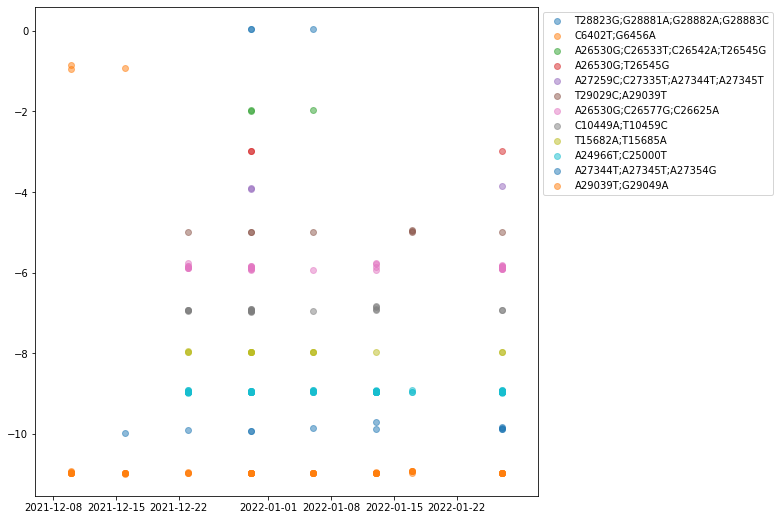

In [57]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(9, 9))

for idx, nt_mutations in enumerate(selected_cryptic_mutations):
    temp_df = merged_df[(merged_df['Date'] >= sampling_date_start) & (merged_df['Date'] < sampling_date_end)]
    temp_df = temp_df[temp_df['Nt Mutations'] == nt_mutations]
    
    scatter = ax.scatter(temp_df['Date'], temp_df['Combined Freq']-idx,
                         marker = 'o',
                         alpha=0.5, 
                         label=nt_mutations)
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))
ax.set_xlim(sampling_date_start, sampling_date_end)

In [58]:
sampling_date_start

Timestamp('2021-12-06 00:00:00')

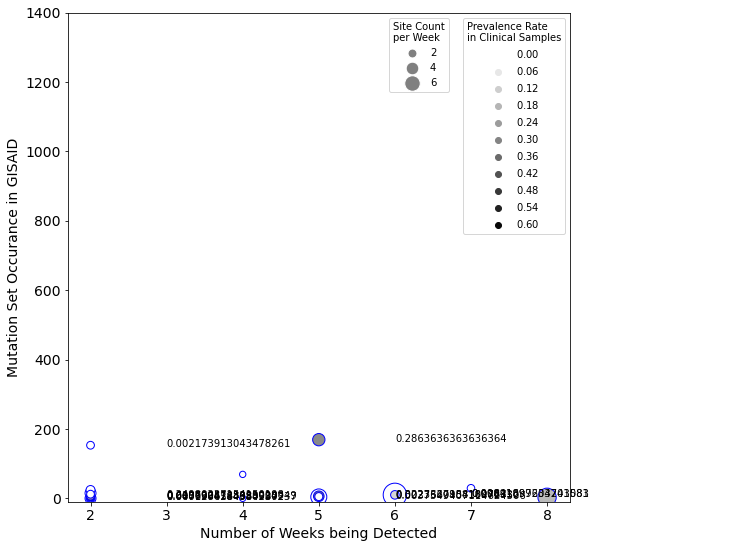

In [59]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(9, 9))

scatter = ax.scatter(check_df['Week Count'], check_df['GISAID Count'],
           s=check_df['Mean Site Occurance']*40,
           c=check_df['Prevalence Rate'],
           cmap='binary',
           marker = 'o', edgecolor='blue',
           alpha=1)

for idx, row in check_df.iterrows():
    if row['Prevalence Rate'] > 0.9:
        ax.annotate(row['Prevalence Rate'], (row['Week Count']+1, row['GISAID Count']+5))
    elif row['Prevalence Rate'] > 0:
        ax.annotate(row['Prevalence Rate'], (row['Week Count']+1, row['GISAID Count']-5))

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Mutation Set Occurance in GISAID', fontsize=fontsize)
#ax.set_xlabel('Number of Weeks the Mutation Set being Detected', fontsize=fontsize+2)
ax.set_ylim(-10,1400)
#ax.set_xlim(-2,38)
#ax.set_xticklabels([])
ax.set_xlabel('Number of Weeks being Detected', fontsize=fontsize)

legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper right", title="Prevalence Rate\nin Clinical Samples")
ax.add_artist(legend1)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='2',
                          markerfacecolor='gray', markersize=np.sqrt(80)),
                   Line2D([0], [0], marker='o', color='w', label='4',
                          markerfacecolor='gray', markersize=np.sqrt(160)),
                   Line2D([0], [0], marker='o', color='w', label='6',
                          markerfacecolor='gray', markersize=np.sqrt(240))]
ax.legend(handles=legend_elements, loc='upper center', title="Site Count\nper Week", bbox_to_anchor=(0.70, 1))

In [60]:
selected_cryptic_mutations

['T28823G;G28881A;G28882A;G28883C',
 'C6402T;G6456A',
 'A26530G;C26533T;C26542A;T26545G',
 'A26530G;T26545G',
 'A27259C;C27335T;A27344T;A27345T',
 'T29029C;A29039T',
 'A26530G;C26577G;C26625A',
 'C10449A;T10459C',
 'T15682A;T15685A',
 'A24966T;C25000T',
 'A27344T;A27345T;A27354G',
 'A29039T;G29049A']

In [61]:
low_key = list(set(full_selected_cryptic_mutations) - set(selected_cryptic_mutations))

In [62]:
high_key = selected_cryptic_mutations.copy()

In [63]:
selected_cryptic_mutations = high_key.copy()

In [64]:
selected_cryptic_mutations

['T28823G;G28881A;G28882A;G28883C',
 'C6402T;G6456A',
 'A26530G;C26533T;C26542A;T26545G',
 'A26530G;T26545G',
 'A27259C;C27335T;A27344T;A27345T',
 'T29029C;A29039T',
 'A26530G;C26577G;C26625A',
 'C10449A;T10459C',
 'T15682A;T15685A',
 'A24966T;C25000T',
 'A27344T;A27345T;A27354G',
 'A29039T;G29049A']

## Mutations

In [65]:
week_offset = dt.timedelta(days = 7)

In [66]:
sampling_date_start

Timestamp('2021-12-06 00:00:00')

In [67]:
clinical_cryptic_df.columns

Index(['SRA Accession ID', 'Run Index', 'Nt Mutations', 'Support DP',
       'Total DP', 'DP1', 'DP2', 'DP3', 'DP4', 'Overlapping Support DP',
       'Inconsistent Support DP', 'Combined Freq', 'Assay Type', 'AvgSpotLen',
       'Bases', 'BioProject', 'BioSample', 'BioSampleModel', 'Bytes',
       'Center Name', 'Collection_Date', 'Consent', 'DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'dehosting_method (run)',
       'Experiment', 'geo_loc_name_country', 'geo_loc_name_country_continent',
       'geo_loc_name', 'GISAID_virus_name', 'Host_disease', 'HOST',
       'Instrument', 'Isolate', 'Isolation_source', 'Library Name',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism',
       'Platform', 'purpose_of_sequencing',
       'raw_sequence_data_processing_method (run)', 'ReleaseDate',
       'create_date', 'version', 'Sample Name', 'SRA Study', 'collected_by',
       'Host_age', 'amplicon__PCR_primer_scheme (run)', 'host_sex', 'taxon',
      

In [68]:
def get_plot_data(mut_label):
    clinical_mutation_df = clinical_cryptic_df[clinical_cryptic_df['Nt Mutations'] == mut_label]
    #clinical_mutation_df = clinical_cryptic_df[(clinical_cryptic_df['Nt Mutations'] == mut_label) & (clinical_cryptic_df['Combined Freq'] >= 0.02)]
    ww_df = merged_df[merged_df['Nt Mutations'] == mut_label]
    x_ticklabels = []
    p_rates = []
    ww_counts = []
    has_data = []
    sample_counts = []
    freqs = []

    for i in range(0, 8):
        start = sampling_date_start + i*week_offset
        end = sampling_date_start + (i+1)*week_offset

        weekly_clinical_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
        ww_count = ww_df[(ww_df['Date'] >= start) & (ww_df['Date'] < end)].shape[0]

        weekly_sample_count = weekly_clinical_df.shape[0]
        sample_counts.append(weekly_sample_count)
        #count_present = weekly_clinical_df[weekly_clinical_df['Support DP'] >= 10].shape[0]
        supported_sample_df = weekly_clinical_df[(weekly_clinical_df['Support DP'] >= 10) & (weekly_clinical_df['Combined Freq'] >= freq_cutoff)]
        supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]
        #supported_sample_df = weekly_clinical_df[(weekly_clinical_df['Overlapping Support DP'] >= 10) & (weekly_clinical_df['Combined Freq'] >= freq_cutoff)]
        count_present = supported_sample_df.shape[0]
        count_no_data = weekly_clinical_df[weekly_clinical_df['Total DP'] == 0].shape[0]
        
        #freq = weekly_clinical_df[weekly_clinical_df['Support DP'] >= 10]['Combined Freq'].mean()
        freq = supported_sample_df['Combined Freq'].mean()
        freqs.append(freq)

        count_exclude_no_data = weekly_sample_count - count_no_data

        if count_exclude_no_data > 0:
            p_rate = count_present/count_exclude_no_data
            has_data.append(2)
        else:
            p_rate = np.nan
            has_data.append(0)

        #time_label = start.strftime('%m/%d/%y') + ' - ' + (end-timedelta(days=1)).strftime('%m/%d/%y')
        time_label = start.strftime('%m-%d-%y')
        x_ticklabels.append(time_label)
        p_rates.append(p_rate)
        if ww_count > 0:
            ww_counts.append(1.1)
        else:
            ww_counts.append(np.nan)
            
    return x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs

In [69]:
clinical_mutation_df = clinical_cryptic_df.copy()
start = sampling_date_start + 0*week_offset
end = sampling_date_start + (7+1)*week_offset
clinical_mutation_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
supported_sample_df = clinical_mutation_df[(clinical_mutation_df['Support DP'] >= 10) & (clinical_mutation_df['Combined Freq'] >= freq_cutoff)]
supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]

In [70]:
len(selected_cryptic_mutations)

12

In [71]:
lineage_mutation_df = pd.pivot_table(supported_sample_df, values='SRA Accession ID', index='lineage', columns='Nt Mutations', 
               aggfunc='count').fillna(0)
lineage_mutation_df

Nt Mutations,A24966T;C25000T,A26530G;C26533T;C26542A;T26545G,A26530G;C26577G;C26625A,A26530G;C26577G;G26634A,A26530G;T26545G,A27259C;C27335T;A27344T;A27345T,A27344T;A27345T;A27354G,A29039T;G29049A,C10449A;T10459C,C6402T;G6456A,T15682A;T15685A,T28823G;G28881A;G28882A;G28883C,T29029C;A29039T
lineage,,,,,,,,,,,,,
AY.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
AY.103,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,4.0,5.0,0.0,0.0
AY.118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
AY.119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
AY.25,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0
AY.25.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
AY.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
AY.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
AY.3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [72]:
lineage_mutation_df = pd.read_csv('houston_lineage_mutation.csv', index_col=0)
lineage_mutation_df

,A24966T;C25000T,A26530G;C26533T;C26542A;T26545G,A26530G;C26577G;C26625A,A26530G;C26577G;G26634A,A26530G;T26545G,A27259C;C27335T;A27344T;A27345T,A27344T;A27345T;A27354G,A29039T;G29049A,C10449A;T10459C,C6402T;G6456A,T15682A;T15685A,T28823G;G28881A;G28882A;G28883C,T29029C;A29039T
lineage,,,,,,,,,,,,,
Delta,0,0,0,0,0,0,6,12,0,11,24,0,0
BA.1.1,4,39,4,0,241,617,90,155,260,0,279,0,3
BA.1.15,27,199,15,1,1004,2463,392,662,1154,0,1291,4,8
Other Omicron,1,3,0,0,18,57,9,15,27,0,31,0,1


In [74]:
#lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()

In [76]:
#lineage_labels[0]

In [78]:
# fig, axes  = plt.subplots(2,2)

# for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
#     ax2 = axes[ax_idx][0]
#     bottom = 0
#     lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
#     lineage_labels = lineage_mutation_df[mut_label].index
    
#     for idx, label in enumerate(lineage_labels):
#         print(label, lineage_values[idx])
#         ax2.bar(0, lineage_values[idx], width=1, label=label, bottom=bottom, edgecolor='black')
#         bottom += lineage_values[idx]
    
#     ax2.set_ylim(0,1)
#     ax2.set_xlim(-0.2,0.2)
#     ax2.set_xticks([])
#     ax2.set_yticks([])
#     break

Text(0.5, 0.98, 'Houston Clinical Samples (Filter SB/DP=10/AF=0.02)')

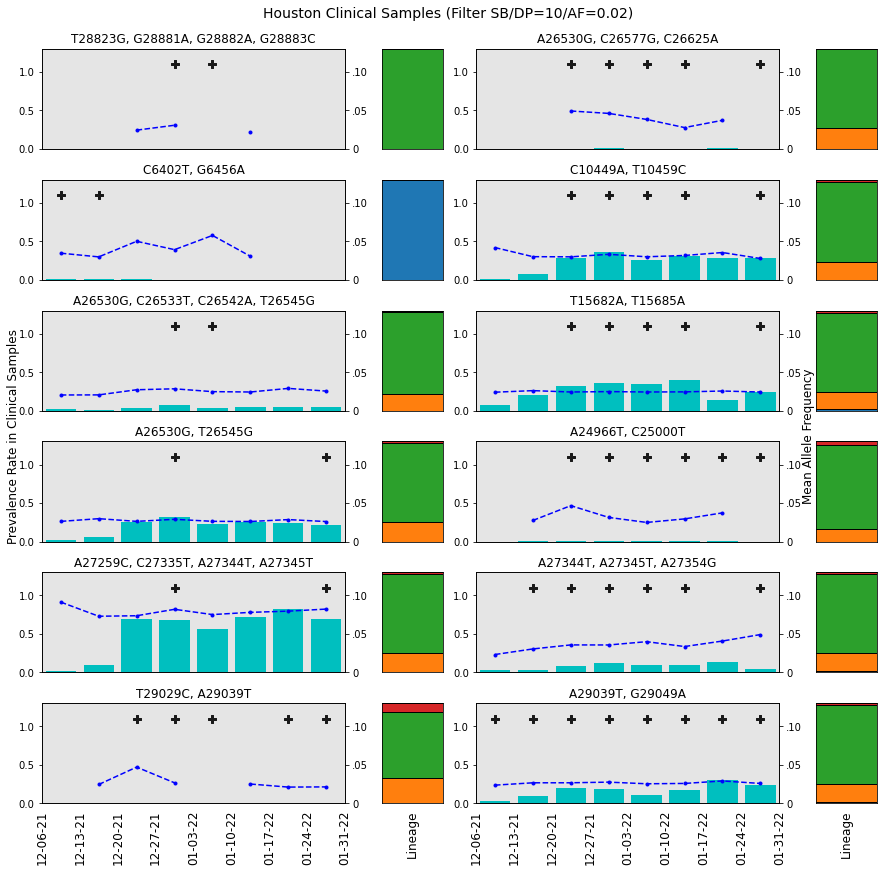

In [79]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 4, figsize=(12, num*2), sharex=False, constrained_layout=True, gridspec_kw={'width_ratios': [5, 1, 5, 1], 'wspace':0.35})

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][2]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][3]
    bottom = 0
    lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
    lineage_labels = lineage_mutation_df[mut_label].index
    for idx, label in enumerate(lineage_labels):
        p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
        bottom += lineage_values[idx]
    
    ax2.set_ylim(0,1)
    ax2.set_xlim(-0.2,0.2)
    ax2.xaxis.set_ticks_position('none')
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][1]
    bottom = 0
    lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
    lineage_labels = lineage_mutation_df[mut_label].index
    for idx, label in enumerate(lineage_labels):
        p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
        bottom += lineage_values[idx]
    
    ax2.set_ylim(0,1)
    ax2.set_xlim(-0.2,0.2)
    ax2.xaxis.set_ticks_position('none')
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.01, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
# fig.text(.41, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(.91, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Houston Clinical Samples (Filter SB/DP=10/AF={freq_cutoff})", fontsize=14)

Text(0.5, 0.98, 'Filter SB/DP=10/AF=0.02')

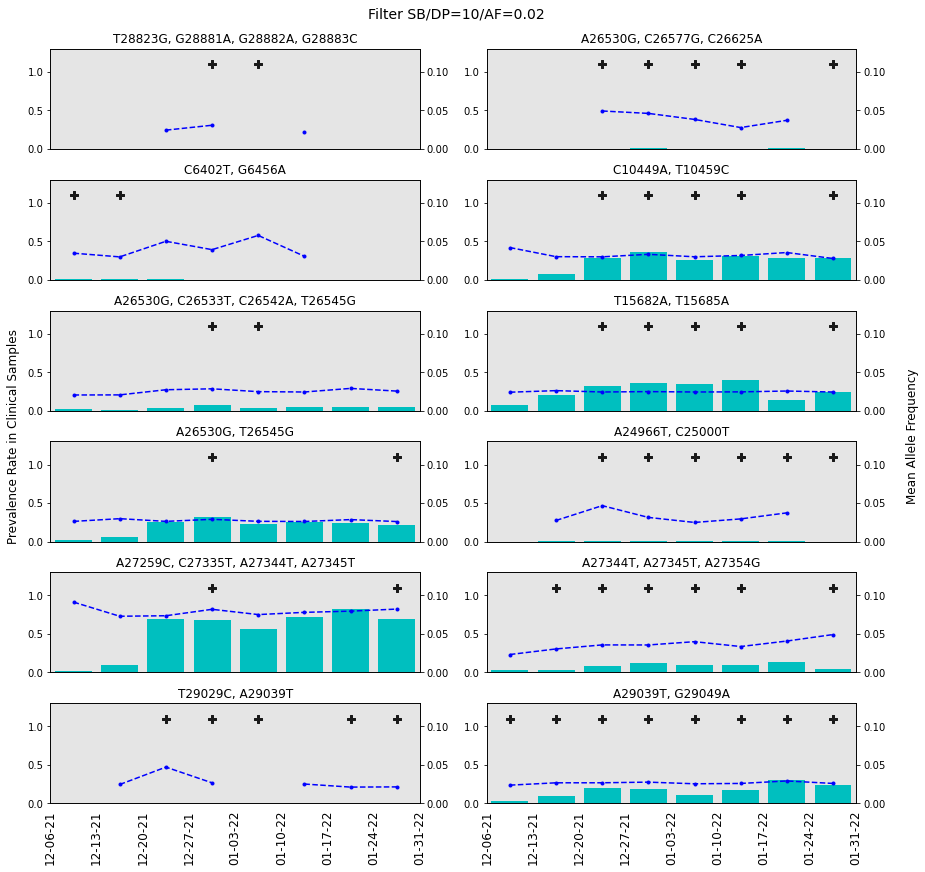

In [80]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 2, figsize=(12, num*2), sharex=True, constrained_layout=True)

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][1]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.02, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(1.02, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Filter SB/DP=10/AF={freq_cutoff}", fontsize=14)

Text(0.5, 1.0, 'Clinical Sample Count')

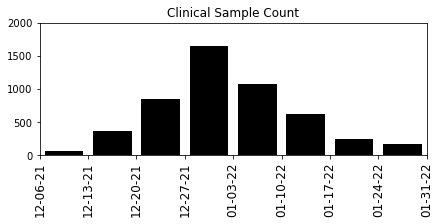

In [81]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(6, 3), sharex=True, constrained_layout=True)

x = np.arange(8)

ax.bar(x, sample_counts, color='black', alpha=1, width=0.8)

ax.set_ylim(0,2000)
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

ax.set_title('Clinical Sample Count')

## Single Sample

In [82]:
check_df[check_df['Prevalence Rate'] > 0]

,Nt Mutations,Mutation Occurance,GISAID Count,Week Count,Prevalence Rate,Mean AF,Mean Site Occurance
65,A26530G;C26577G;G26634A,4,1,2,0.000198,0.052632,2.000000
24,A26530G;C26533T;C26542A;T26545G,3,1,2,0.047628,0.026997,1.500000
15,T28823G;G28881A;G28882A;G28883C,3,4,2,0.000791,0.024791,1.500000
68,A27259C;C27335T;A27344T;A27345T,3,4,2,0.619960,0.078272,1.500000
67,A26530G;T26545G,3,6,2,0.249802,0.027421,1.500000
83,C6402T;G6456A,3,153,2,0.002174,0.044166,1.500000
25,A26530G;C26577G;C26625A,32,4,5,0.003755,0.041833,6.400000
20,C10449A;T10459C,19,169,5,0.286364,0.031538,3.800000
5,T15682A;T15685A,14,6,5,0.322332,0.024508,2.800000
4,T29029C;A29039T,8,5,5,0.002767,0.026920,1.600000


In [83]:
target_mutation = 'A29039T;G29049A'

In [84]:
clinical_mutation_df = clinical_cryptic_df[clinical_cryptic_df['Nt Mutations'] == target_mutation]

af_threshold = 0.02
min_dp = 10

non_zeros = clinical_mutation_df[clinical_mutation_df['Support DP'] >= 10]
no_data = clinical_mutation_df[clinical_mutation_df['Total DP'] == 0]
threshold_df = clinical_mutation_df[(clinical_mutation_df['Combined Freq'] >= af_threshold) & (clinical_mutation_df['Support DP'] >= min_dp)]

if not non_zeros.empty:
    percentile95 = np.percentile(non_zeros['Combined Freq'], 95)
    percentile50 = np.percentile(non_zeros['Combined Freq'], 50)
    percentile05 = np.percentile(non_zeros['Combined Freq'], 5)

In [85]:
bin_labels = ['No Data', 'No support', f'AF<{af_threshold}', f'AF>={af_threshold}']

bin_values = [no_data.shape[0], 
              5060-no_data.shape[0]-non_zeros.shape[0],
              non_zeros.shape[0] - threshold_df.shape[0],
              threshold_df.shape[0]]

bin_values

[0, 2149, 1873, 1038]

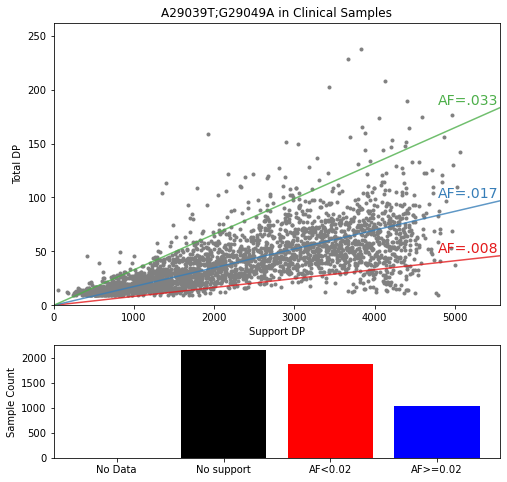

In [86]:
if not non_zeros.empty:
    fontsize = 14
    fig, axes  = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2.5, 1]})
    colors = plt.get_cmap('Set1').colors

    ax = axes[0]

    ax.scatter(non_zeros['Total DP'], non_zeros['Support DP'], marker='.', color='gray')

    x_max = non_zeros['Total DP'].max()*1.1
    y_max = non_zeros['Support DP'].max()*1.1
    ax.set_xlim(0, non_zeros['Total DP'].max()*1.1)
    ax.set_ylim(0, non_zeros['Support DP'].max()*1.1)
    ax.set_ylabel('Total DP')
    ax.set_xlabel('Support DP')


    for color_idx, i in enumerate([percentile05, percentile50, percentile95]):
        line = ax.axline((0,0), slope = i, alpha=0.8, color=colors[color_idx])
        y = i * x_max
        x = i * y_max

        label = "{:.3f}".format(i).lstrip('0')
        if y <= y_max:
            ax.annotate(f"AF={label}", xy=(x_max, y), xytext=(-62, 0),
                        color=line.get_color(), textcoords = 'offset points',
                        size=14, va="bottom")
        else:
            ax.annotate(f"AF={label}", xy=(x_max/y*y_max, y_max), xytext=(0, -10),
                        color=line.get_color(), textcoords = 'offset points',
                        size=14, va="center")
    
    ax.set_title(f'{target_mutation} in Clinical Samples')
    ax = axes[1]

    ax.bar(np.arange(4), bin_values, color = ['gray', 'black', 'red', 'blue'])
    #ax.set_ylim(0,550)
    #ax.set_yticks([0, 100, 200, 300, 400, 500])
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(bin_labels)
    ax.set_ylabel('Sample Count')
    
    

# US Analysis

## Overview

In [360]:
selected_cryptic_mutations

['T28823G;G28881A;G28882A;G28883C',
 'C6402T;G6456A',
 'A26530G;C26533T;C26542A;T26545G',
 'A26530G;T26545G',
 'A27259C;C27335T;A27344T;A27345T',
 'T29029C;A29039T',
 'A26530G;C26577G;C26625A',
 'C10449A;T10459C',
 'T15682A;T15685A',
 'A24966T;C25000T',
 'A27344T;A27345T;A27354G',
 'A29039T;G29049A']

In [361]:
sampled_metadata = pd.read_csv('metadata_non_tx.csv')
sampled_metadata = sampled_metadata.drop('Unnamed: 0', axis=1)
sampled_metadata = sampled_metadata.rename({'Collected': 'Date'}, axis=1)
sampled_metadata['Date'] = pd.to_datetime(sampled_metadata['Date'], format='%m/%d/%Y')
sampled_metadata = sampled_metadata.set_index('AccessionId')

In [362]:
sampled_metadata.shape[0]

8969

## Quality Control

In [371]:
clinical_cryptic_df = pd.read_csv('us_clinical_20_dp4.csv')
us_lineage_df = pd.read_csv("us_lineage_report.csv")[['taxon', 'lineage']]

In [372]:
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,Inconsistent Support DP,Combined Freq
0,SRR17418838,0,A29039T;G29049A;A29301G,0,0,0,0,0,0,0,0,NaN
1,SRR17418838,0,G29050A;A29301G,0,0,0,0,0,0,0,0,NaN
2,SRR17418838,0,A26530G;C26577G;G26634A,0,0,0,0,0,0,0,0,NaN
3,SRR17418838,0,T13078C;T13195C,0,0,0,0,0,0,0,0,NaN
4,SRR17418838,0,A26530G;C26533T;C26542A;T26545G,0,2376,329,2047,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
179315,SRR18050727,8968,T29029C;A29039T,1,2798,1756,2075,0,1,0,0,0.000357
179316,SRR18050727,8968,A24966T;C25000T,0,1442,997,859,0,0,0,0,0.000000
179317,SRR18050727,8968,A27344T;A27345T;A27354G,0,645,403,485,0,0,0,0,0.000000
179318,SRR18050727,8968,T23599G;C23604A;G23642T,0,2640,2621,1082,0,0,0,0,0.000000


In [373]:
clinical_cryptic_df = clinical_cryptic_df.merge(sampled_metadata, how='left', left_on='SRA Accession ID', right_index=True)
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,Inconsistent Support DP,Combined Freq,Repository,Locality,Region,Country,Pango,CDC,Date
0,SRR17418838,0,A29039T;G29049A;A29301G,0,0,0,0,0,0,0,0,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13
1,SRR17418838,0,G29050A;A29301G,0,0,0,0,0,0,0,0,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13
2,SRR17418838,0,A26530G;C26577G;G26634A,0,0,0,0,0,0,0,0,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13
3,SRR17418838,0,T13078C;T13195C,0,0,0,0,0,0,0,0,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13
4,SRR17418838,0,A26530G;C26533T;C26542A;T26545G,0,2376,329,2047,0,0,0,0,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179315,SRR18050727,8968,T29029C;A29039T,1,2798,1756,2075,0,1,0,0,0.000357,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07
179316,SRR18050727,8968,A24966T;C25000T,0,1442,997,859,0,0,0,0,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07
179317,SRR18050727,8968,A27344T;A27345T;A27354G,0,645,403,485,0,0,0,0,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07
179318,SRR18050727,8968,T23599G;C23604A;G23642T,0,2640,2621,1082,0,0,0,0,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07


In [374]:
clinical_cryptic_df = clinical_cryptic_df.merge(us_lineage_df, how='left', left_on='SRA Accession ID', right_on='taxon')
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Combined Freq,Repository,Locality,Region,Country,Pango,CDC,Date,taxon,lineage
0,SRR17418838,0,A29039T;G29049A;A29301G,0,0,0,0,0,0,0,...,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103
1,SRR17418838,0,G29050A;A29301G,0,0,0,0,0,0,0,...,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103
2,SRR17418838,0,A26530G;C26577G;G26634A,0,0,0,0,0,0,0,...,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103
3,SRR17418838,0,T13078C;T13195C,0,0,0,0,0,0,0,...,NaN,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103
4,SRR17418838,0,A26530G;C26533T;C26542A;T26545G,0,2376,329,2047,0,0,0,...,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179315,SRR18050727,8968,T29029C;A29039T,1,2798,1756,2075,0,1,0,...,0.000357,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25
179316,SRR18050727,8968,A24966T;C25000T,0,1442,997,859,0,0,0,...,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25
179317,SRR18050727,8968,A27344T;A27345T;A27354G,0,645,403,485,0,0,0,...,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25
179318,SRR18050727,8968,T23599G;C23604A;G23642T,0,2640,2621,1082,0,0,0,...,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25


In [365]:
combined_freq = []
p_value = []
sb_value = []
supp_dp_updated = []
for idx, row in clinical_cryptic_df.iterrows():
    supp_dp = row['Support DP'] - row['Inconsistent Support DP']
    supp_dp_updated.append(supp_dp)
    
    total_dp = row['Total DP']
    if total_dp != 0:
        combined_freq.append(supp_dp/total_dp)
    else:
        combined_freq.append(np.nan)
    
    dp1, dp2, dp3, dp4 = row['DP1'], row['DP2'], row['DP3'], row['DP4']
    
    if dp3+dp4 > 0 and (dp3/(dp3+dp4) > 0.85 or dp3/(dp3+dp4) < 1-0.85):
        p_value.append(fisher_exact([[dp1, dp2], [dp3, dp4]])[1])
        try:
            sb_value.append(abs((dp3/(dp1+dp3)) - (dp4/(dp2+dp4)))/((dp3+dp4)/(dp1+dp2+dp3+dp4)))
        except ZeroDivisionError:
            sb_value.append(0)
    else:
        p_value.append(1)
        sb_value.append(0)

In [375]:
clinical_cryptic_df['Combined Freq'] = combined_freq
clinical_cryptic_df['SB_p_value'] = p_value
clinical_cryptic_df['SB'] = sb_value
clinical_cryptic_df['Support DP'] = supp_dp_updated

In [376]:
#clinical_cryptic_df = clinical_cryptic_df.merge(sampled_metadata, how='right', left_on='SRA Accession ID', right_index=True)
clinical_cryptic_df['Collection_Date'] = clinical_cryptic_df['Date']

In [377]:
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Region,Country,Pango,CDC,Date,taxon,lineage,SB_p_value,SB,Collection_Date
0,SRR17418838,0,A29039T;G29049A;A29301G,0,0,0,0,0,0,0,...,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103,1.0,0.000000,2021-12-13
1,SRR17418838,0,G29050A;A29301G,0,0,0,0,0,0,0,...,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103,1.0,0.000000,2021-12-13
2,SRR17418838,0,A26530G;C26577G;G26634A,0,0,0,0,0,0,0,...,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103,1.0,0.000000,2021-12-13
3,SRR17418838,0,T13078C;T13195C,0,0,0,0,0,0,0,...,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103,1.0,0.000000,2021-12-13
4,SRR17418838,0,A26530G;C26533T;C26542A;T26545G,0,2376,329,2047,0,0,0,...,Colorado,USA,AY.103,Delta,2021-12-13,SRR17418838,AY.103,1.0,0.000000,2021-12-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179315,SRR18050727,8968,T29029C;A29039T,1,2798,1756,2075,0,1,0,...,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25,1.0,1.845857,2021-12-07
179316,SRR18050727,8968,A24966T;C25000T,0,1442,997,859,0,0,0,...,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25,1.0,0.000000,2021-12-07
179317,SRR18050727,8968,A27344T;A27345T;A27354G,0,645,403,485,0,0,0,...,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25,1.0,0.000000,2021-12-07
179318,SRR18050727,8968,T23599G;C23604A;G23642T,0,2640,2621,1082,0,0,0,...,New Mexico,USA,AY.25,Delta,2021-12-07,SRR18050727,AY.25,1.0,0.000000,2021-12-07


In [378]:
us_df_master = clinical_cryptic_df.copy()

In [379]:
us_df_master.to_csv('filtered_us_df.csv')

## Non-Texas

In [1]:
clinical_cryptic_df = us_df_master.copy()
clinical_cryptic_df.shape

freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 2, figsize=(12, num*2), sharex=True, constrained_layout=True)

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][1]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.02, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(1.02, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Filter SB/DP=10/AF={freq_cutoff}", fontsize=14)

NameError: name 'us_df_master' is not defined

## Maryland & Massachusetts

In [84]:
clinical_cryptic_df = us_df_master.copy()
clinical_cryptic_df = clinical_cryptic_df[(clinical_cryptic_df['Region'] == 'Maryland') | (clinical_cryptic_df['Region'] == 'Massachusetts')]

In [85]:
clinical_cryptic_df.shape

(23522, 22)

Text(0.5, 0.98, 'Filter SB/DP=10/AF=0.02')

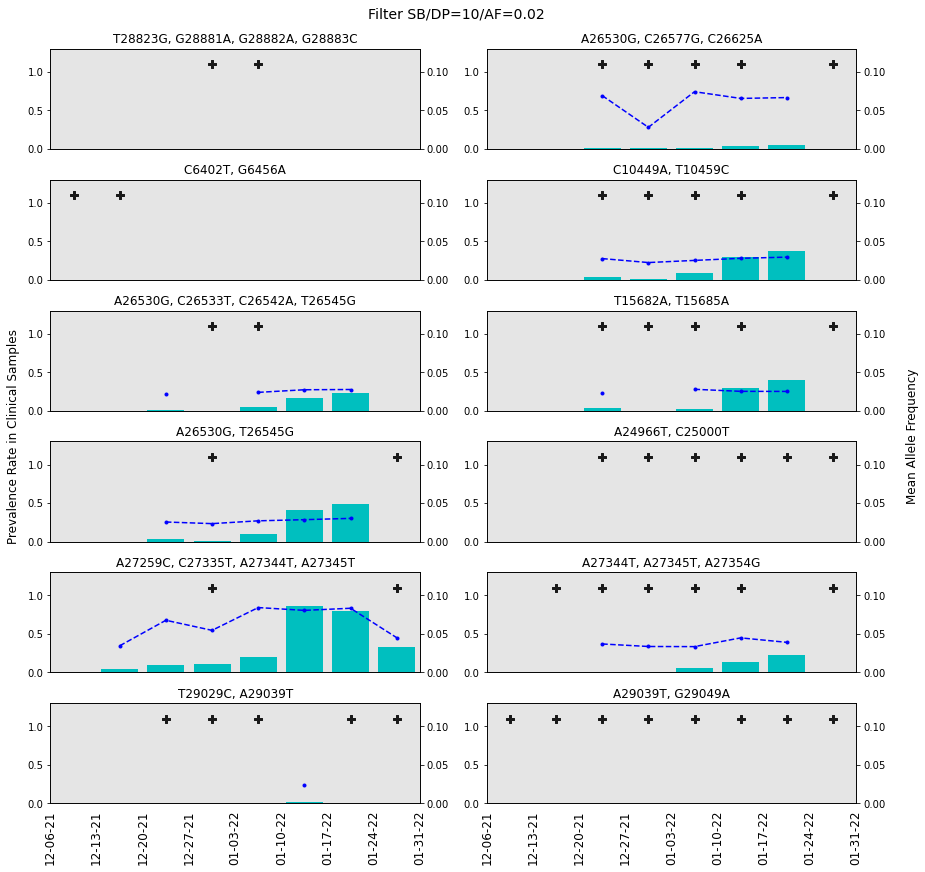

In [86]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 2, figsize=(12, num*2), sharex=True, constrained_layout=True)

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][1]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.02, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(1.02, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Filter SB/DP=10/AF={freq_cutoff}", fontsize=14)

### Massachusetts

In [410]:
clinical_cryptic_df = us_df_master.copy()
clinical_cryptic_df = clinical_cryptic_df[clinical_cryptic_df['Region'] == 'Massachusetts']

In [411]:
clinical_mutation_df = clinical_cryptic_df.copy()
start = sampling_date_start + 0*week_offset
end = sampling_date_start + (7+1)*week_offset
clinical_mutation_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
supported_sample_df = clinical_mutation_df[(clinical_mutation_df['Support DP'] >= 10) & (clinical_mutation_df['Combined Freq'] >= freq_cutoff)]
supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]

In [412]:
supported_sample_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,Region,Country,Pango,CDC,Date,taxon,lineage,SB_p_value,SB,Collection_Date
15906,SRR17470620,795,A27259C;C27335T;A27344T;A27345T,12,122,0,0,0,0,0,...,Massachusetts,USA,BA.1.1,Omicron,2021-12-29,SRR17470620,BA.1.1,1.0,0.000000,2021-12-29
27166,SRR17634514,1358,A27259C;C27335T;A27344T;A27345T,10,352,0,0,0,0,0,...,Massachusetts,USA,BA.1.1,Omicron,2022-01-08,SRR17634514,BA.1.1,1.0,0.000000,2022-01-08
28026,SRR17634619,1401,A27259C;C27335T;A27344T;A27345T,10,152,0,0,0,0,0,...,Massachusetts,USA,BA.1,Omicron,2022-01-08,SRR17634619,BA.1,1.0,0.000000,2022-01-08
29491,SRR17208117,1474,G28881A;G28882A;G28883C;G28954T,38,934,830,7,74,0,0,...,Massachusetts,USA,BA.1.21,Omicron,2021-12-08,SRR17208117,BA.1.21,1.0,1.007743,2021-12-08
32606,SRR18068587,1630,A27259C;C27335T;A27344T;A27345T,19,218,0,0,0,0,0,...,Massachusetts,USA,BA.1,Omicron,2022-01-20,SRR18068587,BA.1,1.0,0.000000,2022-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161526,SRR17471665,8079,A27259C;C27335T;A27344T;A27345T,10,194,0,0,0,0,0,...,Massachusetts,USA,BA.1.1,Omicron,2021-12-27,SRR17471665,BA.1.1,1.0,0.000000,2021-12-27
162806,SRR17471306,8143,A27259C;C27335T;A27344T;A27345T,10,125,0,0,0,0,0,...,Massachusetts,USA,BA.1.1,Omicron,2021-12-27,SRR17471306,BA.1.1,1.0,0.000000,2021-12-27
163072,SRR17471407,8156,A26530G;C26577G;C26625A,12,395,0,0,0,0,0,...,Massachusetts,USA,BA.1.17.2,Omicron,2021-12-27,SRR17471407,BA.1.17.2,1.0,0.000000,2021-12-27
169746,SRR17471264,8490,A27259C;C27335T;A27344T;A27345T,10,163,0,0,0,0,0,...,Massachusetts,USA,BA.1.15,Omicron,2021-12-27,SRR17471264,BA.1.15,1.0,0.000000,2021-12-27


In [413]:
lineage_mutation_df = pd.pivot_table(supported_sample_df, values='SRA Accession ID', index='lineage', columns='Nt Mutations', 
               aggfunc='count').fillna(0)
lineage_mutation_df

Nt Mutations,A26530G;C26577G;C26625A,A26530G;C26577G;G26634A,A27259C;C27335T;A27344T;A27345T,A27344T;A27345T;A27354G,G28881A;G28882A;G28883C;G28954T,T13078C;T13195C
lineage,,,,,,
BA.1,0.0,1.0,8.0,0.0,0.0,1.0
BA.1.1,2.0,0.0,31.0,2.0,0.0,6.0
BA.1.15,0.0,0.0,9.0,0.0,0.0,0.0
BA.1.17.2,1.0,0.0,4.0,0.0,0.0,0.0
BA.1.19,1.0,0.0,1.0,1.0,0.0,0.0
BA.1.20,0.0,0.0,1.0,0.0,0.0,0.0
BA.1.21,0.0,0.0,0.0,0.0,1.0,0.0


In [414]:
lineage_mutation_df = pd.read_csv('ma_lineage_mutation.csv', index_col=0)
lineage_mutation_df

,A26530G;C26577G;C26625A,A26530G;C26577G;G26634A,A27259C;C27335T;A27344T;A27345T,A27344T;A27345T;A27354G,G28881A;G28882A;G28883C;G28954T,T13078C;T13195C
lineage,,,,,,
Delta,0,0,0,0,0,0
BA.1.1,2,0,31,2,0,6
BA.1.15,0,0,9,0,0,0
Other Omicron,2,1,14,1,1,1


In [ ]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 4, figsize=(12, num*2), sharex=False, constrained_layout=True, gridspec_kw={'width_ratios': [5, 1, 5, 1], 'wspace':0.35})

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][2]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][3]
    try:
        bottom = 0
        lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
        lineage_labels = lineage_mutation_df[mut_label].index
        for idx, label in enumerate(lineage_labels):
            p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
            bottom += lineage_values[idx]

        ax2.set_ylim(0,1)
        ax2.set_xlim(-0.2,0.2)
        ax2.xaxis.set_ticks_position('none')
        ax2.set_yticks([])
        ax2.set_xticklabels([])
    except KeyError:
        ax2.bar(0, 1, 1, label=label, bottom=bottom, edgecolor='black', color='white')
        ax2.set_ylim(0,1)
        ax2.set_xlim(-0.2,0.2)
        ax2.xaxis.set_ticks_position('none')
        ax2.set_yticks([])
        ax2.set_xticklabels([])
    
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][1]
    try:
        bottom = 0
        lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
        lineage_labels = lineage_mutation_df[mut_label].index
        for idx, label in enumerate(lineage_labels):
            p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
            bottom += lineage_values[idx]

        ax2.set_ylim(0,1)
        ax2.set_xlim(-0.2,0.2)
        ax2.xaxis.set_ticks_position('none')
        ax2.set_yticks([])
        ax2.set_xticklabels([])
    except KeyError:
        ax2.bar(0, 1, 1, label=label, bottom=bottom, edgecolor='black', color='white')
        ax2.set_ylim(0,1)
        ax2.set_xlim(-0.2,0.2)
        ax2.xaxis.set_ticks_position('none')
        ax2.set_yticks([])
        ax2.set_xticklabels([])
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.01, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
# fig.text(.41, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(.91, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Massachusetts Clinical Samples (Filter SB/DP=10/AF={freq_cutoff})", fontsize=14)

Text(0.5, 0.98, 'Filter SB/DP=10/AF=0.02')

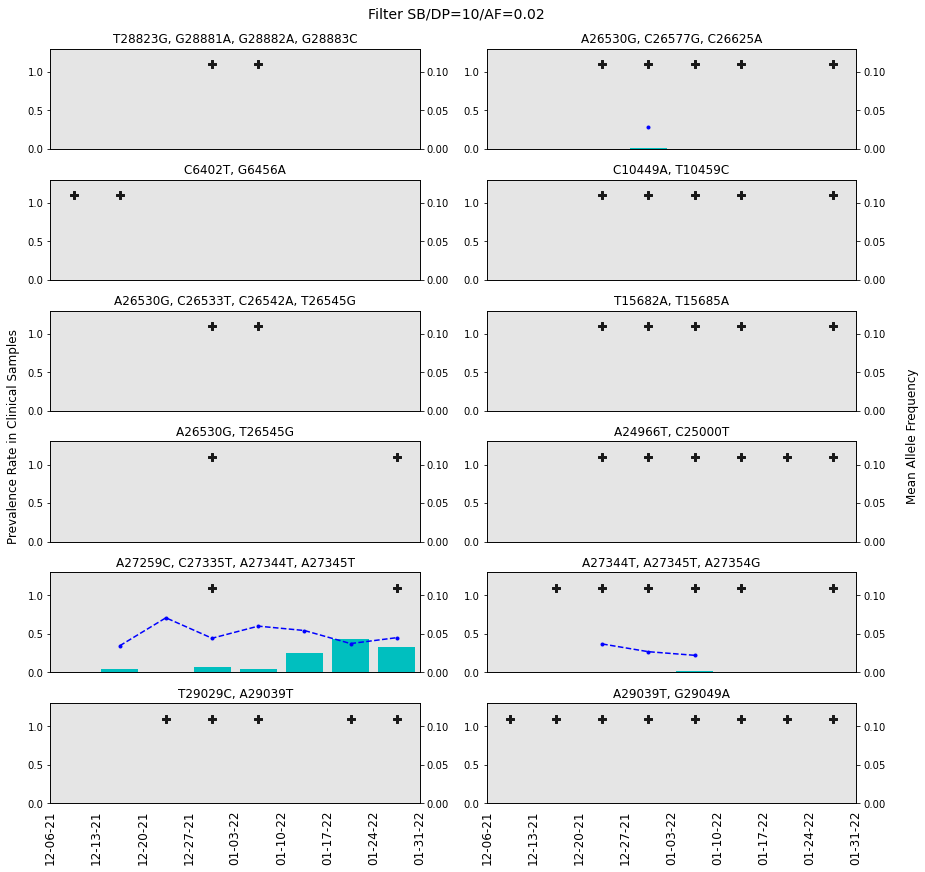

In [87]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 2, figsize=(12, num*2), sharex=True, constrained_layout=True)

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][1]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.02, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(1.02, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Filter SB/DP=10/AF={freq_cutoff}", fontsize=14)

### Maryland

In [395]:
clinical_cryptic_df = us_df_master.copy()
clinical_cryptic_df = clinical_cryptic_df[clinical_cryptic_df['Region'] == 'Maryland']

In [396]:
clinical_mutation_df = clinical_cryptic_df.copy()
start = sampling_date_start + 0*week_offset
end = sampling_date_start + (7+1)*week_offset
clinical_mutation_df = clinical_mutation_df[(clinical_mutation_df['Collection_Date'] >= start) & (clinical_mutation_df['Collection_Date'] < end)]
supported_sample_df = clinical_mutation_df[(clinical_mutation_df['Support DP'] >= 10) & (clinical_mutation_df['Combined Freq'] >= freq_cutoff)]
supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]

In [403]:
lineage_mutation_df = pd.pivot_table(supported_sample_df, values='SRA Accession ID', index='lineage', columns='Nt Mutations', 
               aggfunc='count').fillna(0)
lineage_mutation_df

Nt Mutations,A26530G;C26533T;C26542A;T26545G,A26530G;C26577G;C26625A,A26530G;C26577G;G26634A,A26530G;T26545G,A27259C;C27335T;A27344T;A27345T,A27344T;A27345T;A27354G,C10449A;T10459C,C27807T;A27821C,G22959T;G22992A;C22995A;A23013C;A23040G;G23048A;A23055G;A23063T;T23075C,T15682A;T15685A,T29029C;A29039T
lineage,,,,,,,,,,,
AY.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
BA.1,3.0,1.0,1.0,8.0,22.0,6.0,12.0,0.0,1.0,9.0,1.0
BA.1.1,25.0,9.0,2.0,65.0,129.0,24.0,47.0,1.0,14.0,41.0,1.0
BA.1.1.17,0.0,0.0,0.0,2.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0
BA.1.1.18,0.0,1.0,1.0,2.0,5.0,1.0,2.0,0.0,0.0,2.0,0.0
BA.1.15,8.0,1.0,1.0,16.0,30.0,5.0,11.0,0.0,0.0,8.0,0.0
BA.1.17,1.0,0.0,0.0,5.0,7.0,0.0,4.0,0.0,0.0,3.0,0.0
BA.1.17.2,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
BA.1.18,8.0,1.0,0.0,19.0,38.0,4.0,13.0,0.0,0.0,14.0,0.0


In [400]:
lineage_mutation_df = pd.read_csv('ml_lineage_mutation.csv', index_col=0)
lineage_mutation_df

,A26530G;C26533T;C26542A;T26545G,A26530G;C26577G;C26625A,A26530G;C26577G;G26634A,A26530G;T26545G,A27259C;C27335T;A27344T;A27345T,A27344T;A27345T;A27354G,C10449A;T10459C,C27807T;A27821C,G22959T;G22992A;C22995A;A23013C;A23040G;G23048A;A23055G;A23063T;T23075C,T15682A;T15685A,T29029C;A29039T
lineage,,,,,,,,,,,
Delta,0,0,0,0,0,0,0,0,0,1,0
BA.1.1,25,10,3,69,141,25,50,1,14,44,1
BA.1.15,8,1,1,16,30,5,11,0,0,8,0
Other Omicron,14,2,1,37,79,12,32,0,2,31,1


Text(0.5, 0.98, 'Maryland Clinical Samples (Filter SB/DP=10/AF=0.02)')

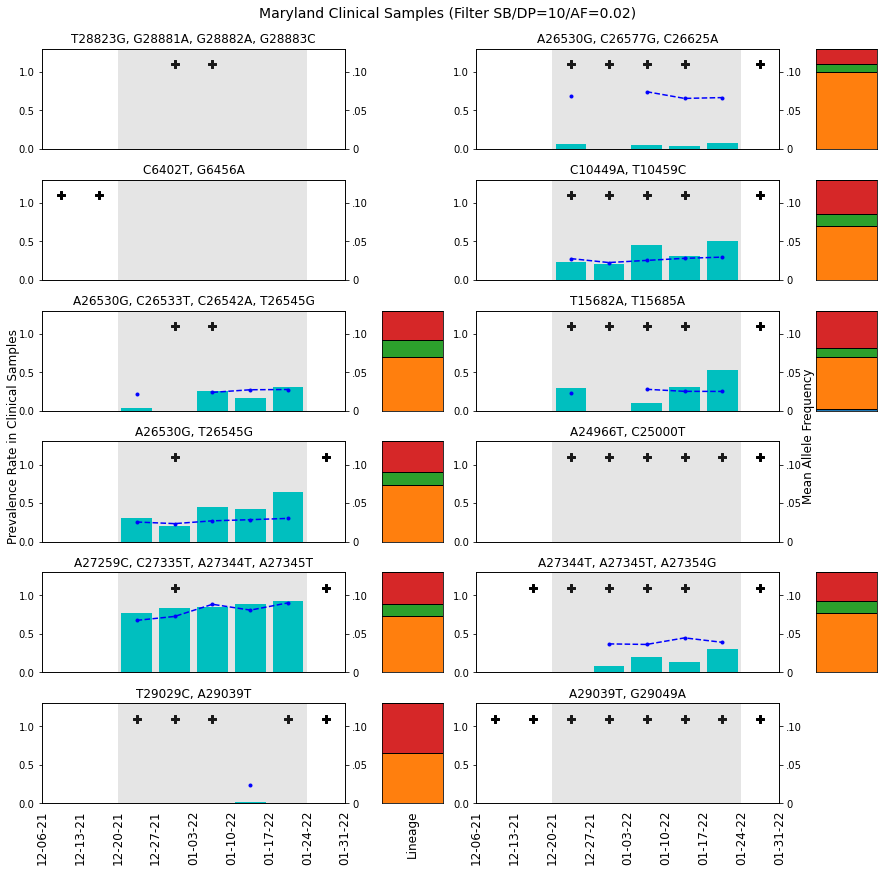

In [402]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 4, figsize=(12, num*2), sharex=False, constrained_layout=True, gridspec_kw={'width_ratios': [5, 1, 5, 1], 'wspace':0.35})

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][2]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][3]
    try:
        bottom = 0
        lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
        lineage_labels = lineage_mutation_df[mut_label].index
        for idx, label in enumerate(lineage_labels):
            p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
            bottom += lineage_values[idx]

        ax2.set_ylim(0,1)
        ax2.set_xlim(-0.2,0.2)
        ax2.xaxis.set_ticks_position('none')
        ax2.set_yticks([])
        ax2.set_xticklabels([])
    except KeyError:
        ax2.axis('off')
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    ax_twin.set_yticks([0,0.05,0.1])
    ax_twin.set_yticklabels(['0','.05','.10'])
    ax.set_xlim(-0.5,7.5)
    ax.set_xticks(np.arange(9)-0.5)
    ax.set_xticklabels([])
    
    ax2 = axes[ax_idx][1]
    try:
        bottom = 0
        lineage_values = lineage_mutation_df[mut_label].values/lineage_mutation_df[mut_label].values.sum()
        lineage_labels = lineage_mutation_df[mut_label].index
        for idx, label in enumerate(lineage_labels):
            p = ax2.bar(0, lineage_values[idx], 1, label=label, bottom=bottom, edgecolor='black')
            bottom += lineage_values[idx]

        ax2.set_ylim(0,1)
        ax2.set_xlim(-0.2,0.2)
        ax2.xaxis.set_ticks_position('none')
        ax2.set_yticks([])
        ax2.set_xticklabels([])
    except KeyError:
        ax2.axis('off')
    
ax2.set_xticks([0])
ax2.set_xticklabels(['Lineage'], rotation=90, fontsize=12)
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.01, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
# fig.text(.41, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)
# fig.text(0.5, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(.91, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Maryland Clinical Samples (Filter SB/DP=10/AF={freq_cutoff})", fontsize=14)

Text(0.5, 0.98, 'Filter SB/DP=10/AF=0.02')

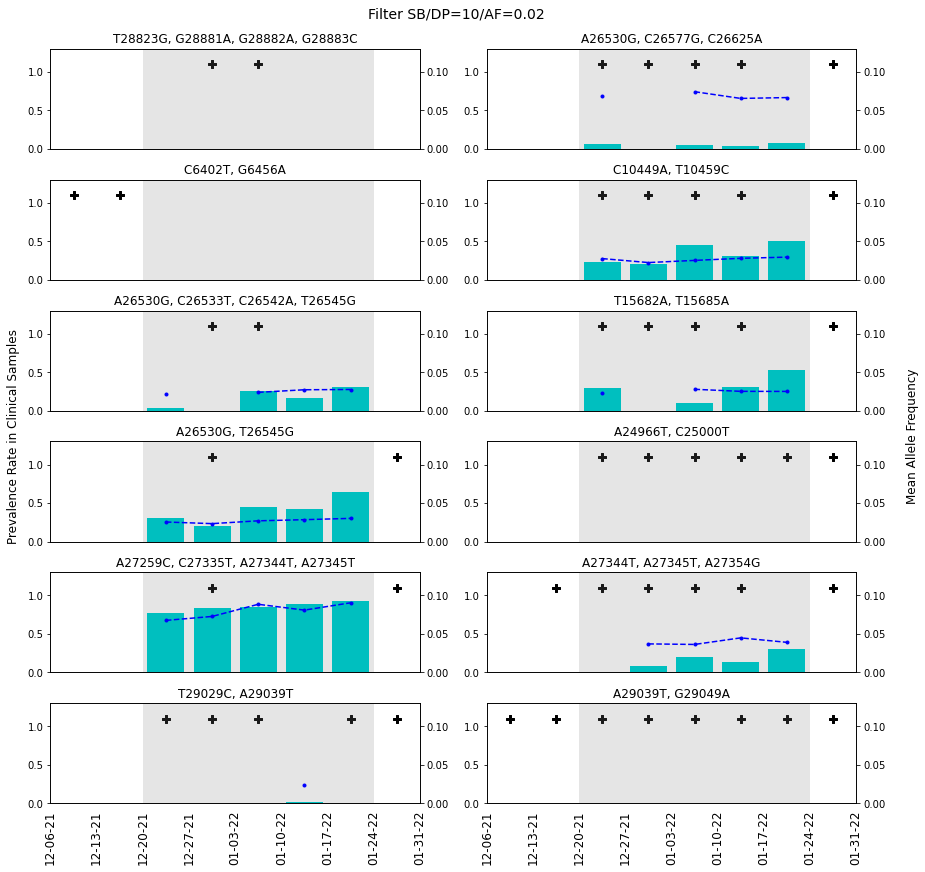

In [401]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 2, figsize=(12, num*2), sharex=True, constrained_layout=True)

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][1]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.02, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(1.02, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Filter SB/DP=10/AF={freq_cutoff}", fontsize=14)

## Exclude Above

In [89]:
clinical_cryptic_df = us_df_master.copy()
clinical_cryptic_df = clinical_cryptic_df[~((clinical_cryptic_df['Region'] == 'Maryland') | (clinical_cryptic_df['Region'] == 'Massachusetts'))]

In [90]:
clinical_cryptic_df.shape

(155801, 22)

Text(0.5, 0.98, 'Filter SB/DP=10/AF=0.02')

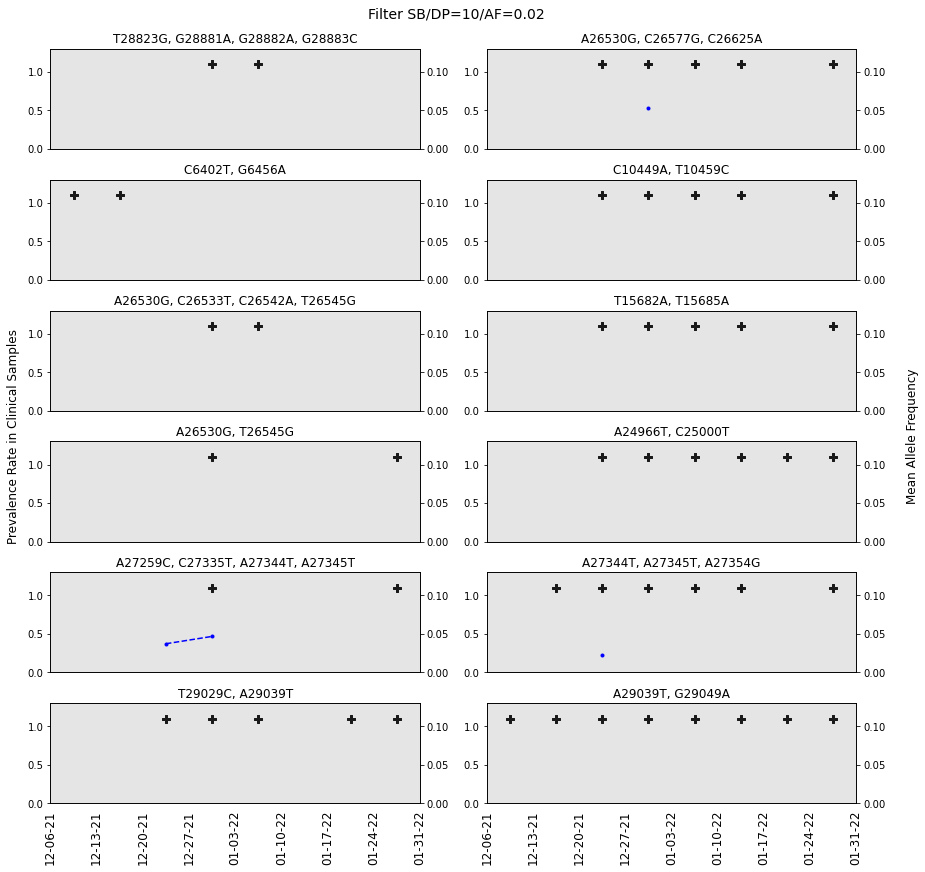

In [91]:
freq_cutoff = 0.02

fontsize = 14
num = int(len(selected_cryptic_mutations)/2)
fig, axes  = plt.subplots(num, 2, figsize=(12, num*2), sharex=True, constrained_layout=True)

x = np.arange(8)

plotted_mut = []

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[-num:]):
    ax = axes[ax_idx][1]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    bar = ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

for ax_idx, mut_label in enumerate(selected_cryptic_mutations[:num]):
    ax = axes[ax_idx][0]
    x_ticklabels, p_rates, has_data, ww_counts, sample_counts, freqs = get_plot_data(mut_label)

    ax.bar(x, has_data, color='gray', alpha=0.2, width=1)
    ax.bar(x, p_rates, color='c')
    ax.scatter(x, ww_counts, marker="P", s=60, color='black')
    ax.set_ylim(0,1.3)
    ax.set_title(", ".join(mut_label.split(';')))
    ax.xaxis.set_ticks_position('none')
    plotted_mut.append(mut_label)
    
    ax_twin = ax.twinx()
    ax_twin.plot(x, freqs, 'b.--')
    #ax_twin.set_ylim(0, np.nanmax(freqs)*2.5)
    ax_twin.set_ylim(0, 0.13)
    
x_ticklabels.append((sampling_date_start+8*week_offset).strftime('%m-%d-%y'))
ax.set_xlim(-0.5,7.5)
ax.set_xticks(np.arange(9)-0.5)
ax.set_xticklabels(x_ticklabels, rotation=90, fontsize=12)

fig.text(-0.02, 0.5, 'Prevalence Rate in Clinical Samples', va='center', rotation='vertical', fontsize=12)
fig.text(1.02, 0.5, 'Mean Allele Frequency', va='center', rotation='vertical', fontsize=12)

fig.suptitle(f"Filter SB/DP=10/AF={freq_cutoff}", fontsize=14)

## Geo Bound

In [92]:
print(sampled_metadata.columns)

pd.DataFrame(pd.pivot_table(sampled_metadata, values='Repository', index='CDC', aggfunc='count'))

Index(['Repository', 'Locality', 'Region', 'Country', 'Pango', 'CDC', 'Date'], dtype='object')


,Repository
CDC,
Delta,2720
None,4
Omicron,6245


In [245]:
selected_cryptic_mutations

['T28823G;G28881A;G28882A;G28883C',
 'C6402T;G6456A',
 'A26530G;C26533T;C26542A;T26545G',
 'A26530G;T26545G',
 'A27259C;C27335T;A27344T;A27345T',
 'T29029C;A29039T',
 'A26530G;C26577G;C26625A',
 'C10449A;T10459C',
 'T15682A;T15685A',
 'A24966T;C25000T',
 'A27344T;A27345T;A27354G',
 'A29039T;G29049A']

In [287]:
clinical_cryptic_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,SB_p_value,SB,Repository,Locality,Region,Country,Pango,CDC,Date,Collection_Date
0.0,SRR17418838,0.0,A29039T;G29049A;A29301G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,2021-12-13
1.0,SRR17418838,0.0,G29050A;A29301G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,2021-12-13
2.0,SRR17418838,0.0,A26530G;C26577G;G26634A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,2021-12-13
3.0,SRR17418838,0.0,T13078C;T13195C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,2021-12-13
4.0,SRR17418838,0.0,A26530G;C26533T;C26542A;T26545G,0.0,2376.0,329.0,2047.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,Colorado,USA,AY.103,Delta,2021-12-13,2021-12-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179315.0,SRR18050727,8968.0,T29029C;A29039T,1.0,2798.0,1756.0,2075.0,0.0,1.0,0.0,...,1.0,1.845857,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,2021-12-07
179316.0,SRR18050727,8968.0,A24966T;C25000T,0.0,1442.0,997.0,859.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,2021-12-07
179317.0,SRR18050727,8968.0,A27344T;A27345T;A27354G,0.0,645.0,403.0,485.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,2021-12-07
179318.0,SRR18050727,8968.0,T23599G;C23604A;G23642T,0.0,2640.0,2621.0,1082.0,0.0,0.0,0.0,...,1.0,0.000000,NCBI,None,New Mexico,USA,AY.25,Delta,2021-12-07,2021-12-07


In [307]:
target_mutation = 'A27259C;C27335T;A27344T;A27345T'

In [308]:
supported_sample_df = clinical_cryptic_df[(clinical_cryptic_df['Support DP'] >= 10) & (clinical_cryptic_df['Combined Freq'] >= freq_cutoff) & (clinical_cryptic_df['Nt Mutations'] == target_mutation)]
supported_sample_df = supported_sample_df[(supported_sample_df['SB_p_value'] > 0.05)]
supported_sample_df

,SRA Accession ID,Run Index,Nt Mutations,Support DP,Total DP,DP1,DP2,DP3,DP4,Overlapping Support DP,...,SB_p_value,SB,Repository,Locality,Region,Country,Pango,CDC,Date,Collection_Date
15126.0,SRR17472747,756.0,A27259C;C27335T;A27344T;A27345T,10.0,231.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,New Hampshire,USA,BA.1.18,Omicron,2021-12-25,2021-12-25
93946.0,SRR17391124,4697.0,A27259C;C27335T;A27344T;A27345T,10.0,321.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,Connecticut,USA,BA.1.1,Omicron,2021-12-22,2021-12-22
100886.0,SRR17615918,5044.0,A27259C;C27335T;A27344T;A27345T,10.0,299.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,Rhode Island,USA,BA.1.19,Omicron,2021-12-31,2021-12-31
104026.0,SRR17615491,5201.0,A27259C;C27335T;A27344T;A27345T,15.0,218.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,Rhode Island,USA,BA.1.1,Omicron,2021-12-31,2021-12-31
107006.0,SRR17615759,5350.0,A27259C;C27335T;A27344T;A27345T,12.0,320.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,Rhode Island,USA,BA.1.17.2,Omicron,2021-12-31,2021-12-31
123146.0,SRR17494817,6157.0,A27259C;C27335T;A27344T;A27345T,15.0,278.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,Connecticut,USA,BA.1.1,Omicron,2021-12-30,2021-12-30
148226.0,SRR17507544,7414.0,A27259C;C27335T;A27344T;A27345T,10.0,423.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,Connecticut,USA,BA.1,Omicron,2022-01-02,2022-01-02
169006.0,SRR17471357,8453.0,A27259C;C27335T;A27344T;A27345T,14.0,221.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,NCBI,None,New York,USA,BA.1.17.2,Omicron,2021-12-27,2021-12-27


In [309]:
pd.DataFrame(pd.pivot_table(supported_sample_df, values='Repository', index='Region', aggfunc='count'))

,Repository
Region,
Connecticut,3
New Hampshire,1
New York,1
Rhode Island,3


In [310]:
pd.DataFrame(pd.pivot_table(supported_sample_df, values='Repository', index='Pango', aggfunc='count'))

,Repository
Pango,
BA.1,1
BA.1.1,3
BA.1.17.2,2
BA.1.18,1
BA.1.19,1
